In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
from torch.utils.data import Dataset, DataLoader, DistributedSampler
from torch.multiprocessing.spawn import spawn
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import VOCSegmentation
from torchvision.io import read_image
from torchvision.transforms import v2

In [4]:
# model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn(pretrained=True)
model = nn.DataParallel(model.to(device))
model.eval()

# data
def preprocess(img_path, device):
    img = Image.open(img_path).convert("RGB")
    transform = v2.Compose([
        v2.ToTensor(),  # [0,255]→[0,1], C×H×W
        v2.Normalize(mean=[0.485,0.456,0.406],
                    std=[0.229,0.224,0.225]),
    ])
    tensor = transform(img).unsqueeze(0).to(device)  # バッチ次元追加→[1,C,H,W]
    return img, tensor

orig_img, x = preprocess("./cat.jpeg", device)

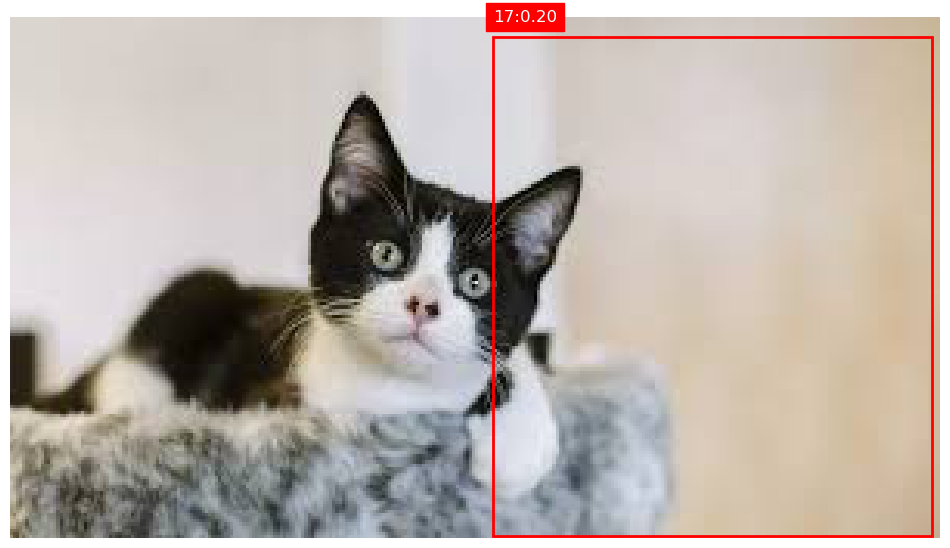

In [7]:
with torch.no_grad():
    outputs = model(x)  
    # outputs は list[dict] 型、outputs[0]["boxes"], ["labels"], ["scores"]

boxes  = outputs[0]["boxes"].cpu()
labels = outputs[0]["labels"].cpu()
scores = outputs[0]["scores"].cpu()

# 結果を可視化
fig,ax = plt.subplots(1, figsize=(12,8))
ax.imshow(orig_img)
for box, label, score in zip(boxes, labels, scores):
    if score < 0.2: continue
    x1,y1,x2,y2 = box
    rect = patches.Rectangle(
        (x1,y1), x2-x1, y2-y1,
        linewidth=2, edgecolor="r", facecolor="none"
    )
    ax.add_patch(rect)
    ax.text(x1, y1-5, f"{label.item()}:{score:.2f}", 
            color="white", backgroundcolor="r", fontsize=12)
ax.axis("off")
plt.show()